<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment_4/assignment_4_skeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group Number: 28

# Student 1:
## Danylo Vasylyshyn, 1815709

# Student 2:
## Sam van der Velden, 1017871

# Student 3:
## Stan Meijerink, 1222737 

# Imports

In [ ]:
import numpy as np
import pickle
import requests
import torch
import torch.nn as nn
from torch.optim import Adam
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
# other imports go here
import seaborn as sns
sns.set_style('white')

# Data loading and inspection

In [ ]:
# load and inspect data
data_location = 'https://surfdrive.surf.nl/files/index.php/s/K3ArFDQJb5USQ6K/download'
data_request = requests.get(data_location)
full_data = pickle.loads(data_request.content)

In [ ]:
full_data.keys()

dict_keys(['unlabeled_data', 'labeled_data', 'representative_set_1', 'representative_set_2'])

In [ ]:
full_data['representative_set_1']['labels']

array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.]], dtype=float32)

In [ ]:
torch.set_printoptions(profile="full")
#next(iter(train_loader))
torch.set_printoptions(profile="default") # reset

# Data augmentation and pipeline

In [ ]:
class UnlabeledDataset(Dataset):
  def __init__(self, array):
    self.data = torch.FloatTensor(array) / 255

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    return self.data[idx]

In [ ]:
class LabeledDataset(Dataset):
  def __init__(self, input):
    self.data = torch.FloatTensor(input['data']) / 255
    self.target = torch.FloatTensor(input['labels'])

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    return (self.data[idx], self.target[idx])

In [ ]:
batch_size = 100

unlabeled_data = UnlabeledDataset(full_data['unlabeled_data'])
train_loader = DataLoader(dataset=unlabeled_data, batch_size=batch_size, shuffle=True)

In [ ]:
labeled_data_train = LabeledDataset({'data' : full_data['labeled_data']['data'][0:1000], 'labels': full_data['labeled_data']['labels'][0:1000]})
classifier_train_loader_train = DataLoader(dataset=labeled_data_train, batch_size=batch_size, shuffle=True)

labeled_data_test = LabeledDataset({'data' : full_data['labeled_data']['data'][1000:1500], 'labels': full_data['labeled_data']['labels'][1000:1500]})
classifier_train_loader_test = DataLoader(dataset=labeled_data_test, batch_size=batch_size, shuffle=True)

anomaly_data_1 = LabeledDataset(full_data['representative_set_1'])
anomaly_data_loader_1 = DataLoader(dataset=anomaly_data_1, batch_size=1, shuffle=True)

anomaly_data_2 = LabeledDataset(full_data['representative_set_2'])
anomaly_data_loader_2 = DataLoader(dataset=anomaly_data_2, batch_size=1, shuffle=True)

# Model definitions

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 10, kernel_size=5, stride=1, padding=0)
        self.conv2 = torch.nn.Conv2d(10, 30, kernel_size=5, stride=2, padding=0)
        self.conv3 = torch.nn.Conv2d(30, 30, kernel_size=5, stride=2, padding=0)
        self.fc_input = nn.Linear(input_dim, hidden_dim)
        self.fc_hidden = nn.Linear(hidden_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_sigma = nn.Linear (hidden_dim, latent_dim)
        
    def forward(self, x):
        #h = torch.relu(self.conv1(x))
        #h = torch.relu(self.conv2(h))
        #h = torch.relu(self.conv3(h))
        h = x.view(batch_size, -1)
        h = torch.relu(self.fc_input(h))
        h = torch.relu(self.fc_hidden(h))
        mu = self.fc_mu(h)
        log_sigma = self.fc_sigma(h)
        z = self.reparameterization(mu, log_sigma)

        return z, mu, log_sigma
    
    def reparameterization(self, mu, log_sigma):
        sigma = torch.exp(log_sigma)
        epsilon = torch.randn_like(sigma).to(DEVICE)
        z = mu + sigma * epsilon
        
        return z

In [ ]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc_hidden1 = nn.Linear(latent_dim, hidden_dim)
        self.fc_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_output = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        h = torch.relu(self.fc_hidden1(x))
        h = torch.relu(self.fc_hidden2(h))
        x_reconstr = torch.sigmoid(self.fc_output(h))
        return x_reconstr

In [ ]:
class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
                
    def forward(self, x):
        z, mu, log_sigma = self.encoder(x)
        x_reconstr = self.decoder(z)
        
        return x_reconstr, mu, log_sigma

In [ ]:
class Classifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Classifier, self).__init__()
        self.fc_input = nn.Linear(input_dim, hidden_dim)
        self.fc_hidden = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.Softmax()
        
    def forward(self, x):
        h = torch.relu(self.fc_input(x))
        h = self.fc_hidden(h)
        h = self.softmax(h)

        return h

In [ ]:
x_dim  = 1024
hidden_dim = 400
latent_dim = 30 

cuda = False 
DEVICE = torch.device("cuda" if cuda else "cpu")

encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim=hidden_dim, output_dim=x_dim)

vae = VAE(encoder=encoder, decoder=decoder).to(DEVICE)

In [ ]:
lr = 1e-3

def loss_function(x, x_reconstr, mu, log_sigma):
    reconstr_loss = nn.functional.mse_loss(x_reconstr, x, reduction='sum')
    kl_loss = 0.5 * torch.sum(mu.pow(2) + (2*log_sigma).exp() - 2*log_sigma - 1)
    total_loss = reconstr_loss + kl_loss
    return total_loss, reconstr_loss, kl_loss

optimizer = Adam(vae.parameters(), lr=lr)

In [ ]:
epochs = 50

print("Start training VAE...")
vae.train()

for epoch in range(epochs):
    overall_loss = 0
    overall_reconstr_loss = 0
    overall_kl_loss = 0
    for batch_idx, (x) in enumerate(train_loader):
        x = x.to(DEVICE)
        optimizer.zero_grad()
        x_reconstr, mu, log_sigma = vae(x)
        x = x.view(batch_size, x_dim)

        loss, reconstr_loss, kl_loss = loss_function(x, x_reconstr, mu, log_sigma)

        overall_loss += loss.item()
        overall_reconstr_loss += reconstr_loss.item()
        overall_kl_loss += kl_loss.item()
        
        loss.backward()
        optimizer.step()
        
    n_datapoints = batch_idx * batch_size
    print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss / n_datapoints, "\tReconstruction Loss:", overall_reconstr_loss / n_datapoints, "\tKL Loss:", overall_kl_loss / n_datapoints)
    
print("Training complete!")

Start training VAE...
	Epoch 1 	Average Loss:  51.14584797862874 	Reconstruction Loss: 46.99007789876931 	KL Loss: 4.155770242094533
	Epoch 2 	Average Loss:  31.205581460017495 	Reconstruction Loss: 25.31431567100024 	KL Loss: 5.891265774877835
	Epoch 3 	Average Loss:  27.77305150330297 	Reconstruction Loss: 22.008949276250302 	KL Loss: 5.764102217626387
	Epoch 4 	Average Loss:  26.68943332981419 	Reconstruction Loss: 20.769522822906612 	KL Loss: 5.919910537542984
	Epoch 5 	Average Loss:  26.066272849300194 	Reconstruction Loss: 20.041338668293015 	KL Loss: 6.024934211642585
	Epoch 6 	Average Loss:  25.58598433918014 	Reconstruction Loss: 19.52699000531642 	KL Loss: 6.058994373925405
	Epoch 7 	Average Loss:  25.23926587196851 	Reconstruction Loss: 19.100153935848518 	KL Loss: 6.139111929050284
	Epoch 8 	Average Loss:  25.00151239932734 	Reconstruction Loss: 18.811560657162463 	KL Loss: 6.189951678537494
	Epoch 9 	Average Loss:  24.768941296905165 	Reconstruction Loss: 18.51885357124004

Below, we are going to generate some clothing items by generating some latent space representations. We choose the numbers in the generated latent space representation to be close to 0, because our fitted distribution has a mean of 0, so we know there are some representative and likely instances around 0.

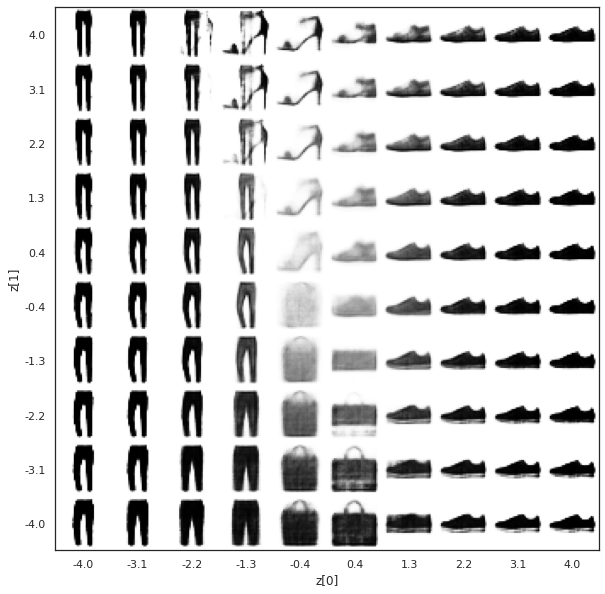

In [ ]:
n = 10
digit_size = 32
figure = np.zeros((digit_size * n, digit_size * n))

#generating the numbers around 0 
grid_x = np.linspace(-4, 4, n)
grid_y = np.linspace(-4, 4, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([xi if k % 2 == 0 else yi for k in range(latent_dim)], dtype=np.float32)
        z_sample_torch = torch.from_numpy(z_sample).to(DEVICE)
        x_decoded_torch = decoder(z_sample_torch)
        x_decoded = x_decoded_torch.cpu().detach().numpy()
        x_decoded = np.reshape(x_decoded, (x_decoded.shape[0], -1))
        #print(x_decoded.shape)
        digit = x_decoded.reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
                j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
start_range = digit_size // 2
end_range = n * digit_size + start_range
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.imshow(figure, cmap='Greys')
plt.show()

# Training and validation loop

In [ ]:
input_dim  = 30
hidden_dim = 200
output_dim = 5  
cuda = False  
DEVICE = torch.device("cuda" if cuda else "cpu")

classifier = Classifier(input_dim, hidden_dim, output_dim)

In [ ]:
epochs = 150

criterion = torch.nn.CrossEntropyLoss()

optimizer = Adam(classifier.parameters(), lr=lr)
for epoch in range(epochs):
    overall_loss = 0
    overall_loss_test = 0
    train_accuracy = 0
    valid_accuracy = 0
  
    for batch_idx, (data, label) in enumerate(classifier_train_loader_train):
        data = data.to(DEVICE)
        optimizer.zero_grad()
        prediction = classifier(vae.encoder(data)[0])
        #print(f"reconstruction: {x_reconstr.shape}\n mu: {mu} \n sigma: {log_sigma}")
        #print(x.shape)
        #print(prediction.shape)
        loss = criterion(prediction, label)
        train_accuracy += torch.sum(torch.where(torch.argmax(prediction, dim=1) == torch.argmax(label, dim=1), 1, 0))
        overall_loss += loss.item()
        
        loss.backward()
        optimizer.step()

    n_datapoints_train = (batch_idx + 1) * batch_size

    for batch_idx, (data, label) in enumerate(classifier_train_loader_test):
        data = data.to(DEVICE)
        prediction = classifier(vae.encoder(data)[0])
        #print(prediction)
        #print(f"reconstruction: {x_reconstr.shape}\n mu: {mu} \n sigma: {log_sigma}")
        #print(x.shape)
        #print(prediction.shape)
        loss = criterion(prediction, label)


        overall_loss_test += loss.item()
        valid_accuracy += torch.sum(torch.where(torch.argmax(prediction, dim=1) == torch.argmax(label, dim=1), 1, 0))
        #print(valid_accuracy)

    n_datapoints_test = (batch_idx + 1) * batch_size
    print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss / n_datapoints_train, "\tVal Loss: ", overall_loss_test / n_datapoints_test, "Train Acc: ", train_accuracy / n_datapoints_train, "Valid Acc: ", valid_accuracy / n_datapoints_test)    
print("Training complete!")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()


	Epoch 1 	Average Loss:  0.01596353530883789 	Val Loss:  0.015810213804244994 Train Acc:  tensor(0.2920) Valid Acc:  tensor(0.4140)
	Epoch 2 	Average Loss:  0.015719115376472474 	Val Loss:  0.015574270486831665 Train Acc:  tensor(0.4560) Valid Acc:  tensor(0.5420)
	Epoch 3 	Average Loss:  0.015449009776115418 	Val Loss:  0.015350530385971069 Train Acc:  tensor(0.5770) Valid Acc:  tensor(0.6060)
	Epoch 4 	Average Loss:  0.015185728907585143 	Val Loss:  0.015064017295837402 Train Acc:  tensor(0.6220) Valid Acc:  tensor(0.6140)
	Epoch 5 	Average Loss:  0.014850515127182006 	Val Loss:  0.014691569805145265 Train Acc:  tensor(0.6490) Valid Acc:  tensor(0.6680)
	Epoch 6 	Average Loss:  0.014531970024108887 	Val Loss:  0.014393181324005126 Train Acc:  tensor(0.6640) Valid Acc:  tensor(0.6360)
	Epoch 7 	Average Loss:  0.014125023365020752 	Val Loss:  0.013960296869277954 Train Acc:  tensor(0.6870) Valid Acc:  tensor(0.6880)
	Epoch 8 	Average Loss:  0.013802008748054505 	Val Loss:  0.0136631188

# Inspection, Validation, and Analysis

In [ ]:
print(torch.argmax(classifier(vae.encoder(data)[0]), dim=1))
print(torch.argmax(label, dim=1))
predicted = torch.argmax(classifier(vae.encoder(data)[0]), dim=1)
ground_truth = torch.argmax(label, dim=1)

tensor([1, 2, 1, 0, 2, 4, 4, 3, 0, 1, 1, 1, 3, 3, 2, 1, 3, 1, 4, 4, 2, 4, 0, 4,
        1, 3, 4, 3, 3, 4, 3, 2, 4, 2, 0, 2, 1, 2, 4, 4, 0, 4, 0, 1, 2, 0, 4, 4,
        4, 3, 2, 2, 3, 2, 1, 3, 0, 1, 4, 0, 4, 4, 1, 3, 3, 1, 1, 3, 2, 1, 4, 2,
        0, 2, 1, 2, 2, 0, 3, 3, 2, 3, 3, 0, 3, 1, 4, 1, 0, 3, 4, 1, 3, 1, 2, 1,
        2, 1, 3, 0])
tensor([1, 2, 1, 0, 2, 4, 2, 3, 0, 2, 1, 1, 3, 3, 2, 1, 3, 1, 4, 4, 2, 1, 0, 4,
        1, 3, 4, 3, 3, 4, 3, 1, 4, 2, 0, 2, 1, 2, 2, 4, 0, 4, 0, 1, 2, 0, 1, 4,
        4, 3, 2, 2, 3, 2, 1, 3, 0, 1, 1, 0, 4, 4, 3, 3, 3, 1, 1, 3, 4, 1, 4, 2,
        0, 2, 1, 2, 4, 0, 3, 3, 2, 3, 3, 0, 3, 1, 4, 2, 0, 3, 2, 1, 3, 1, 2, 1,
        2, 2, 3, 0])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()


this is little visuaization of class predictions, where green cells denotes correctly predicted classes and red ones incorrectly predicted. Real life labels for the data were not given, just the one-hot encoded. It's possible to deduce those from the pictures classified for the given task, which will be done later, but this is just one more way to visualize the performance of the model.

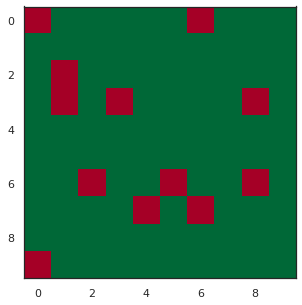

In [ ]:
plt.imshow(torch.where(predicted == ground_truth, 1, 0).view(10, 10), cmap='RdYlGn')

In [ ]:
classifier.eval()

Classifier(
  (fc_input): Linear(in_features=30, out_features=200, bias=True)
  (fc_hidden): Linear(in_features=200, out_features=5, bias=True)
  (softmax): Softmax(dim=None)
)

# Anomaly detection and ROC curves for anomaly detection
In the below roc curves the we consider anomaly to be a positive class and normal to be negative. Therefore true positive rate represents how much of the anomaly data was detected and false positive rate - how much of the normal data was considered anomaly.


In [ ]:
#def elbo_elementwise(x, x_reconstr, mu, log_sigma):
#    reconstr_loss = torch.sum(nn.functional.mse_loss(x_reconstr, x, reduction='none'), dim=1)
#    constant_term = x_dim * 0.5 * np.log(np.pi)  # assuming sigma=1/sqrt(2)
#    kl_loss = 0.5 * torch.sum(mu.pow(2) + (2*log_sigma).exp() - 2*log_sigma - 1, dim=1)
#    elbo = - reconstr_loss - constant_term - kl_loss
#    return elbo

In [ ]:
def elbo_elementwise(x, x_reconstr, mu, log_sigma):
    reconstr_loss = nn.functional.mse_loss(x_reconstr, x, reduction='sum')
    kl_loss = 0.5 * torch.sum(mu.pow(2) + (2*log_sigma).exp() - 2*log_sigma - 1)
    constant_term = x_dim * 0.5 * np.log(np.pi)  # assuming sigma=1/sqrt(2)
    return - reconstr_loss - constant_term - kl_loss

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Using a target size (torch.Size([1024])) that is different to the input size (torch.Size([1, 1024])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  


[-657.2503051757812, -682.2150268554688, -634.7239990234375, -622.3145141601562, -602.8203735351562, -672.4325561523438, -626.5706787109375, -829.8311767578125, -611.89697265625, -673.503173828125, -616.6157836914062, -654.3489990234375, -661.16650390625, -612.9359130859375, -683.2380981445312, -618.468017578125, -640.4708251953125, -641.916259765625, -602.3931274414062, -648.5458374023438, -632.5653076171875, -619.4432373046875, -628.5383911132812, -700.501708984375, -622.8629150390625, -625.7285766601562, -615.31005859375, -651.531005859375, -744.0376586914062, -693.953369140625, -613.6630859375, -625.5590209960938, -637.9845581054688, -769.3833618164062, -660.4495849609375, -620.442138671875, -629.3004760742188, -623.86181640625, -722.3997192382812, -718.4041748046875, -622.0301513671875, -643.9141235351562, -613.6755981445312, -639.8032836914062, -674.840576171875, -678.7385864257812, -733.443115234375, -661.4931030273438, -656.3441772460938, -689.4008178710938, -662.030029296875, 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


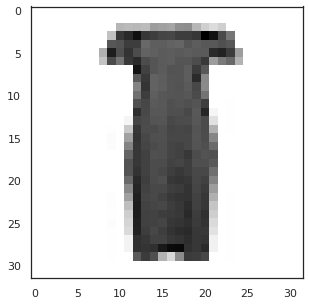

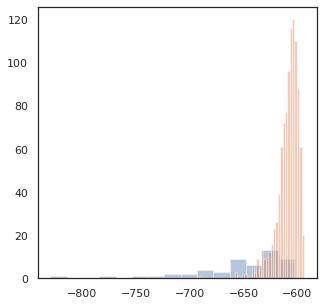

In [ ]:
import seaborn as sns
sns.set_style('white')

batch_size = 1

anomaly_likelihood = []
normal_likelihood = []
for data, label in anomaly_data_loader_1:
  x_reconstr, mu, log_sigma = vae(data)
  likelihood = elbo_elementwise(data.view(-1), x_reconstr, mu, log_sigma)
  if label[0][5] == 1:
    anomaly_likelihood.append(likelihood)
    plt.imshow(data[0][0], cmap='Greys')
  else:
    normal_likelihood.append(likelihood)

for i in range(len(anomaly_likelihood)):
  anomaly_likelihood[i] = anomaly_likelihood[i].detach().numpy().item()
for i in range(len(normal_likelihood)):
  normal_likelihood[i] = normal_likelihood[i].detach().numpy().item()
print(anomaly_likelihood)
fig, ax = plt.subplots()
sns.distplot(anomaly_likelihood, ax=ax, bins=15, kde=False)
sns.distplot(normal_likelihood, ax=ax, kde=False)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


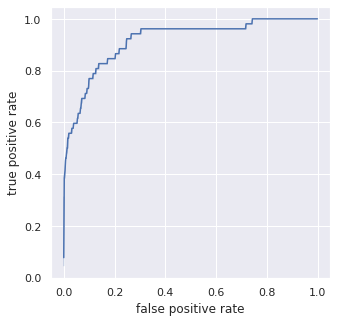

In [ ]:
fpr = []
tpr = []
normal_likelihood = np.sort(np.array(normal_likelihood))
anomaly_likelihood = np.sort(np.array(anomaly_likelihood))
total = len(normal_likelihood) + len(anomaly_likelihood)
iter1 = 0
iter2 = 0
for d in range(total):
    true_positive_rate = iter1 / (iter1 + len(anomaly_likelihood) - iter1)
    false_positive_rate = (iter2) / (iter2 + len(normal_likelihood) - iter2)
    tpr.append(true_positive_rate)
    fpr.append(false_positive_rate)
    if(iter1 < len(anomaly_likelihood) and iter2 < len(normal_likelihood)):
      if(anomaly_likelihood[iter1] <= normal_likelihood[iter2]):
        iter1 += 1
      else:
        iter2 += 1
    elif (iter1 >= len(anomaly_likelihood)):
      iter2 += 1
    else:
      iter1 += 1

sns.set(rc={'figure.figsize':(5, 5)})
sns.lineplot(fpr, tpr)
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.show()
sns.set_style('white')

In [ ]:
fpr1 = fpr
tpr1 = tpr

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Using a target size (torch.Size([1024])) that is different to the input size (torch.Size([1, 1024])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  


[-696.5037231445312, -611.9481201171875, -650.6790771484375, -657.422119140625, -636.1334228515625, -665.2199096679688, -617.599853515625, -630.0811767578125, -661.510986328125, -622.9180297851562, -658.204833984375, -605.7990112304688, -623.4901123046875, -705.9634399414062, -614.4404907226562, -711.6865234375, -640.1358642578125, -628.1176147460938, -669.5838012695312, -619.2335815429688, -667.6063232421875, -628.8690795898438, -638.9407958984375, -618.17822265625, -615.8658447265625, -710.8768920898438, -672.6783447265625, -624.7330322265625, -647.3878173828125, -665.0275268554688, -631.870849609375, -724.1510620117188, -637.4312133789062, -653.448974609375, -672.3768920898438, -604.7627563476562, -710.1649169921875, -653.5716552734375, -632.29052734375, -656.7897338867188, -617.060546875, -612.2495727539062, -649.1035766601562, -644.0843505859375, -767.125732421875, -616.5226440429688, -626.7100219726562, -649.2190551757812, -609.45458984375, -747.4888305664062, -640.294189453125, 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


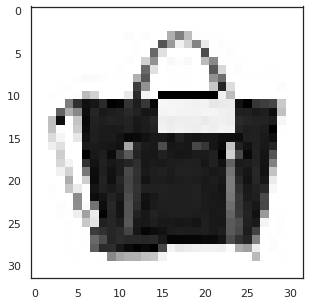

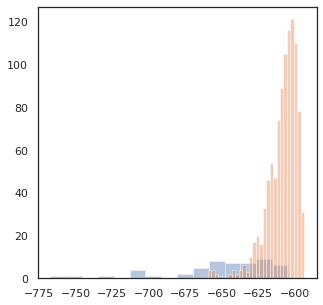

In [ ]:
sns.set_style('white')

batch_size = 1

anomaly_likelihood = []
normal_likelihood = []
for data, label in anomaly_data_loader_2:
  x_reconstr, mu, log_sigma = vae(data)
  likelihood = elbo_elementwise(data.view(-1), x_reconstr, mu, log_sigma)
  if label[0][5] == 1:
    anomaly_likelihood.append(likelihood)
    plt.imshow(data[0][0], cmap='Greys')
  else:
    normal_likelihood.append(likelihood)

for i in range(len(anomaly_likelihood)):
  anomaly_likelihood[i] = anomaly_likelihood[i].detach().numpy().item()
for i in range(len(normal_likelihood)):
  normal_likelihood[i] = normal_likelihood[i].detach().numpy().item()
print(anomaly_likelihood)
fig, ax = plt.subplots()
sns.distplot(anomaly_likelihood, ax=ax, bins=15, kde=False)
sns.distplot(normal_likelihood, ax=ax, kde=False)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


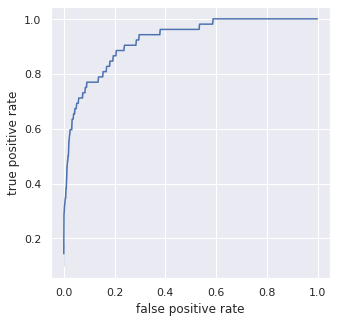

In [ ]:
fpr = []
tpr = []
normal_likelihood = np.sort(np.array(normal_likelihood))
anomaly_likelihood = np.sort(np.array(anomaly_likelihood))
total = len(normal_likelihood) + len(anomaly_likelihood)
iter1 = 0
iter2 = 0
for d in range(total):
    true_positive_rate = iter1 / (iter1 + len(anomaly_likelihood) - iter1)
    false_positive_rate = (iter2) / (iter2 + len(normal_likelihood) - iter2)
    tpr.append(true_positive_rate)
    fpr.append(false_positive_rate)
    if(iter1 < len(anomaly_likelihood) and iter2 < len(normal_likelihood)):
      if(anomaly_likelihood[iter1] <= normal_likelihood[iter2]):
        iter1 += 1
      else:
        iter2 += 1
    elif (iter1 >= len(anomaly_likelihood)):
      iter2 += 1
    else:
      iter1 += 1

sns.set(rc={'figure.figsize':(5, 5)})
sns.lineplot(fpr, tpr)
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.show()
sns.set_style('white')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


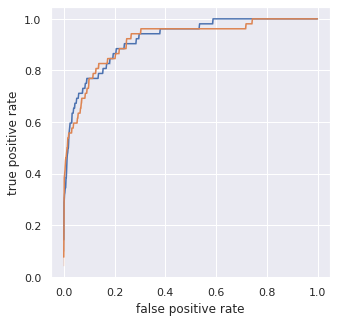

In [ ]:
sns.set(rc={'figure.figsize':(5, 5)})
sns.lineplot(fpr, tpr)
sns.lineplot(fpr1, tpr1)
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.show()
sns.set_style('white')
